GHCN V2 Temperatures ANOM (C)  CR 1200KM 1880-present

GLOBAL Temperature Anomalies in .01 C     base period: 1951-1980

http://climatecode.org/

In [1]:
import os
import git


if not os.path.exists('ccc-gistemp'):
    git.Git().clone('https://github.com/ClimateCodeFoundation/ccc-gistemp.git')

if not os.path.exists('madqc'):
    git.Git().clone('https://github.com/ClimateCodeFoundation/madqc.git')

It seems that

http://data.giss.nasa.gov/gistemp/sources_v3/GISTEMPv3_sources.tar.gz

and 

http://data.giss.nasa.gov/pub/gistemp/SBBX.ERSST.gz

are down, so let's use a local copy instead.

In [2]:
!mkdir -p ccc-gistemp/input

!cp GISTEMPv3_sources.tar.gz SBBX.ERSST.gz ccc-gistemp/input

In [3]:
%cd ccc-gistemp/

/home/filipe/Dropbox/Meetings/2018-PythonSul/keynote/notebooks/ccc-gistemp


We don't really need `pypy` for the fetch phase, but the code is Python 2 and the notebook is Python 3, so this is just a lazy way to call py2k code from a py3k notebook ;-p

PS: we are also using the International Surface Temperature Initiative data (ISTI).

In [4]:
!pypy tool/fetch.py isti

Fetching ftp://ftp.ncdc.noaa.gov/pub/data/globaldatabank/monthly/stage3/recommended/results/recommended-ghcn_format.monthly.stage3.v1.1.1.20180307.tar.gz to input/isti.v1.tar.gz
  116679933/116679933 [100%]00/116679933 [2%][4%]6679933 [6%]79933 [9%]0/116679933 [11%] [13%]840000/116679933 [15%]79933 [17%]/116679933 [21%][23%]76000/116679933 [25%]9933 [27%]116679933 [31%]34%]2000/116679933 [36%]933 [38%] 46968000/116679933 [40%]16679933 [42%]4%]000/116679933 [46%]33 [48%]59104000/116679933 [50%]6679933 [52%]%]00/116679933 [56%]3 [58%]1240000/116679933 [61%]679933 [63%]]0/116679933 [67%] [69%]376000/116679933 [71%]79933 [73%]/116679933 [77%][79%]12000/116679933 [81%]9933 [83%]0/116679933 [86%]]6679933 [90%]107376000/116679933 [92%]933 [94%]56000/116679933 [96%][98%]
  ... input/isti.merged.inv from merged.monthly.stage3.v1.1.1.inv.
  ... input/isti.merged.dat from merged.monthly.stage3.v1.1.1.dat.


QC the ISTI data.

In [5]:
!../madqc/mad.py --progress input/isti.merged.dat

 100% ZIXLT831324 TAVG 1960 180       


We need to copy the ISTI data into the `input` directory.

In [6]:
!cp isti.merged.qc.dat input/isti.merged.qc.dat

!cp input/isti.merged.inv input/isti.merged.qc.inv

Here is where `pypy` is really needed, this step takes ~35 minutes on valina `python` but only ~100 seconds on `pypy`.

In [7]:
!pypy tool/run.py -p 'data_sources=isti.merged.qc.dat;element=TAVG' -s 0-1,3-5

Fetching ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/v3/ghcnm.tavg.latest.qca.tar.gz to input/ghcnm.tavg.latest.qca.tar.gz
  12780302/12780302 [100%]%]780302 [21%]44000/12780302 [41%]2%]2 [82%]
  ... input/ghcnm.tavg.qca.dat from ./ghcnm.v3.3.0.20180405/ghcnm.tavg.v3.3.0.20180405.qca.dat.
input/GISTEMPv3_sources.tar.gz already exists.
  ... input/oisstv2_mod4.clim.gz from GISTEMP_sources/STEP4_5/input_files/oisstv2_mod4.clim.gz.
  ... input/sumofday.tbl from GISTEMP_sources/STEP1/input_files/sumofday.tbl.
  ... input/v3.inv from GISTEMP_sources/STEP1/input_files/v3.inv.
  ... input/ushcn3.tbl from GISTEMP_sources/STEP1/input_files/ushcn3.tbl.
  ... input/mcdw.tbl from GISTEMP_sources/STEP1/input_files/mcdw.tbl.
  ... input/Ts.strange.v3.list.IN_full from GISTEMP_sources/STEP0/input_files/Ts.strange.v3.list.IN_full.
  ... input/antarc2.list from GISTEMP_sources/STEP0/input_files/antarc2.list.
  ... input/antarc3.list from GISTEMP_sources/STEP0/input_files/antarc3.list.
  ... input/antarc1.lis

Python `gistemp` saves the results in the same format as the Fortran program but it ships with `gistemp2csv.py` to make it easier to read the data with `pandas`.

In [8]:
!pypy tool/gistemp2csv.py result/*.txt

In [9]:
import pandas as pd


df = pd.read_csv(
    'result/landGLB.Ts.GHCN.CL.PA.csv',
    skiprows=3,
    index_col=0,
    na_values=('*****', '****'),
)

Let's use `sklearn` to compute the full trend...

In [10]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score


reg0 = linear_model.LinearRegression()

series0 = df['J-D'].dropna()
y = series0.values
X = series0.index.values[:, None]

reg0.fit(X, y)
y_pred0 = reg0.predict(X)
R2_0 = mean_squared_error(y, y_pred0)
var0 = r2_score(y, y_pred0)

 and the past 30 years trend.

In [11]:
reg1 = linear_model.LinearRegression()

series1 = df['J-D'].dropna().iloc[-30:]
y = series1.values
X = series1.index.values[:, None]
reg1.fit(X, y)
y_pred1 = reg1.predict(X)
R2_1 = mean_squared_error(y[-30:], y_pred1)
var1 = r2_score(y[-30:], y_pred1)

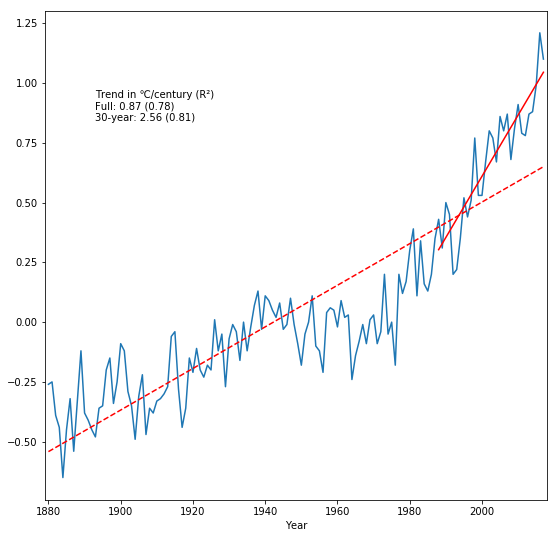

In [12]:
%matplotlib inline

ax = df.plot.line(y='J-D', figsize=(9, 9), legend=None)
ax.plot(series0.index, y_pred0, 'r--')
ax.plot(series1.index, y_pred1, 'r')
ax.set_xlim([1879, 2018])

leg = f"""Trend in ℃/century (R²)
Full: {reg0.coef_[0]*100:0.2f} ({var0:0.2f})
30-year: {reg1.coef_[0]*100:0.2f} ({var1:0.2f})
"""

ax.text(0.10, 0.75, leg, transform=ax.transAxes);